이 코드는 다음의 reference의 코드를 가져왔습니다.


ref1: https://github.com/AndreyTulyakov/Simple-U-net-Example

ref2: https://www.tensorflow.org/tutorials/images/segmentation


In [ ]:
#이미지와 annotations을 복사
#!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz #이미지를 다운로드
#!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz #annotations를 다운로드

In [1]:
#oxford-pet 데이터셋 구글 드라이브에 넣고, 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# images.tar.gz파일 앞축풀기
!tar -xf /content/drive/MyDrive/oxford_pet/images.tar.gz

# annotations.tar.gz파일 압축풀기
!tar -xf /content/drive/MyDrive/oxford_pet/annotations.tar.gz

In [3]:
ls

annotations/  drive/  images/  model.png  sample_data/


In [4]:
# 기본 세팅
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate 
from tensorflow.keras.layers import Dense,  Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image # pip install pillow

import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
#GPU메모리 부족현상을 해결하기 위해
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
# oxford_pets 데이터파일을 열어서 test dataset과 training dataset만드는 함수
def load_oxford_pets_2(target_size= (128, 128), test_split_rate= 0.2):
    input_file = "./annotations/list.txt"
    file = open(input_file)
    list_txt = file.readlines()
    file.close()
    
    list_txt = list_txt[6:]     # delete header
    np.random.shuffle(list_txt)

    # load dataset
    dataset = {"name": [], "label": [], "image": [ ], "mask": [] }
    for line in list_txt:
        image_name, class_id, species,  breed_id = line.split()
        image_file= "./images/"+ image_name + ".jpg"
        mask_file = "./annotations/trimaps/"+ image_name + ".png"

        if os.path.exists(image_file) and os.path.exists(mask_file):
            dataset["name"].append(image_name)
            dataset["label"].append(int(species)-1) # Cat: 0, Dog: 1

            # read image and scale to target_size
            img = image.load_img(image_file, target_size=target_size)
            img = image.img_to_array(img)  # (128, 128, 3)
            dataset["image"].append(img)

            # read mask
            mask = image.load_img(mask_file, target_size= target_size,
                                             color_mode='grayscale')    
            mask = image.img_to_array(mask) # (128, 128, 1)
            dataset["mask"].append(mask)

    # change list to np.array
    dataset["name"]  = np.array(dataset["name"])
    dataset["label"] = np.array(dataset["label"])
    dataset["image"] = np.array(dataset["image"])    
    dataset["mask"]  = np.array(dataset["mask"])
    
    # split dataset into train_dataset and test_dataset
    dataset_total = dataset['image'].shape[0]
    test_size     = int(dataset_total*test_split_rate)
    train_size    = dataset_total - test_size

    train_dataset = {}
    train_dataset["name"]= dataset["name"][:train_size]
    train_dataset["label"]= dataset["label"][:train_size]
    train_dataset["image"]= dataset["image"][:train_size]
    train_dataset["mask"]= dataset["mask"][:train_size]
    
    test_dataset  = {}    
    test_dataset["name"] = dataset["name"][train_size:]
    test_dataset["label"]= dataset["label"][train_size:]
    test_dataset["image"]= dataset["image"][train_size:]
    test_dataset["mask"]= dataset["mask"][train_size:]     
    return train_dataset, test_dataset

In [7]:
# dataset loading
train_dataset, test_dataset = load_oxford_pets_2() # target_size= (128, 128)
print("train_dataset['image'].shape=", train_dataset['image'].shape)# (5880, 128, 128, 3)
print("test_dataset['image'].shape=",  test_dataset['image'].shape) # (1469, 128, 128, 3)

x_train = train_dataset["image"]/255.0
x_test = test_dataset["image"]/255.0

y_train = train_dataset["mask"]-1 # [1, 2, 3] -> [0, 1, 2]
y_test = test_dataset["mask"]-1
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)

train_dataset['image'].shape= (5880, 128, 128, 3)
test_dataset['image'].shape= (1469, 128, 128, 3)
x_train.shape =  (5880, 128, 128, 3)
y_train.shape =  (5880, 128, 128, 1)


In [8]:
display([x_train[100], y_train[100]])

[array([[[0.88235295, 0.827451  , 0.6509804 ],
         [0.8862745 , 0.8352941 , 0.6313726 ],
         [0.9137255 , 0.8627451 , 0.6862745 ],
         ...,
         [0.4117647 , 0.38039216, 0.29803923],
         [0.41568628, 0.37254903, 0.3019608 ],
         [0.49019608, 0.44705883, 0.36862746]],
 
        [[0.98039216, 0.92941177, 0.7921569 ],
         [0.9490196 , 0.9019608 , 0.7529412 ],
         [0.8039216 , 0.75686276, 0.60784316],
         ...,
         [0.50980395, 0.47058824, 0.3647059 ],
         [0.49803922, 0.44313726, 0.34117648],
         [0.37254903, 0.3137255 , 0.23921569]],
 
        [[0.94509804, 0.90588236, 0.76862746],
         [0.9254902 , 0.87058824, 0.69411767],
         [0.90588236, 0.84705883, 0.6862745 ],
         ...,
         [0.52156866, 0.45882353, 0.36078432],
         [0.4862745 , 0.46666667, 0.34901962],
         [0.53333336, 0.5058824 , 0.40392157]],
 
        ...,
 
        [[0.85490197, 0.827451  , 0.7137255 ],
         [0.8745098 , 0.84705883, 0.73333

In [11]:
#UNet 구조 정의
def unet_1(input_shape=(128, 128, 3), num_classes=3):
  
    inputs = Input(shape=input_shape)
    # 128
    
    down1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(32, (3, 3), activation='relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPool2D()(down1)
    # 64

    center = Conv2D(512, (3, 3), activation='relu', padding='same')(down1_pool)
    center = BatchNormalization()(center)
    center = Conv2D(512, (3, 3), activation='relu', padding='same')(center)
    center = BatchNormalization()(center)
    # center

    up1 = UpSampling2D((2, 2))(center)
    up1 = concatenate([down1, up1], axis=3) # try comment this line, i.e, without this shortcut(skip connection)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(up1)   
    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=RMSprop(0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])    
    return model

#4:
UNET = unet_1()
UNET.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 128, 128, 32  128        ['conv2d_8[0][0]']               
 rmalization)                   )                                                           

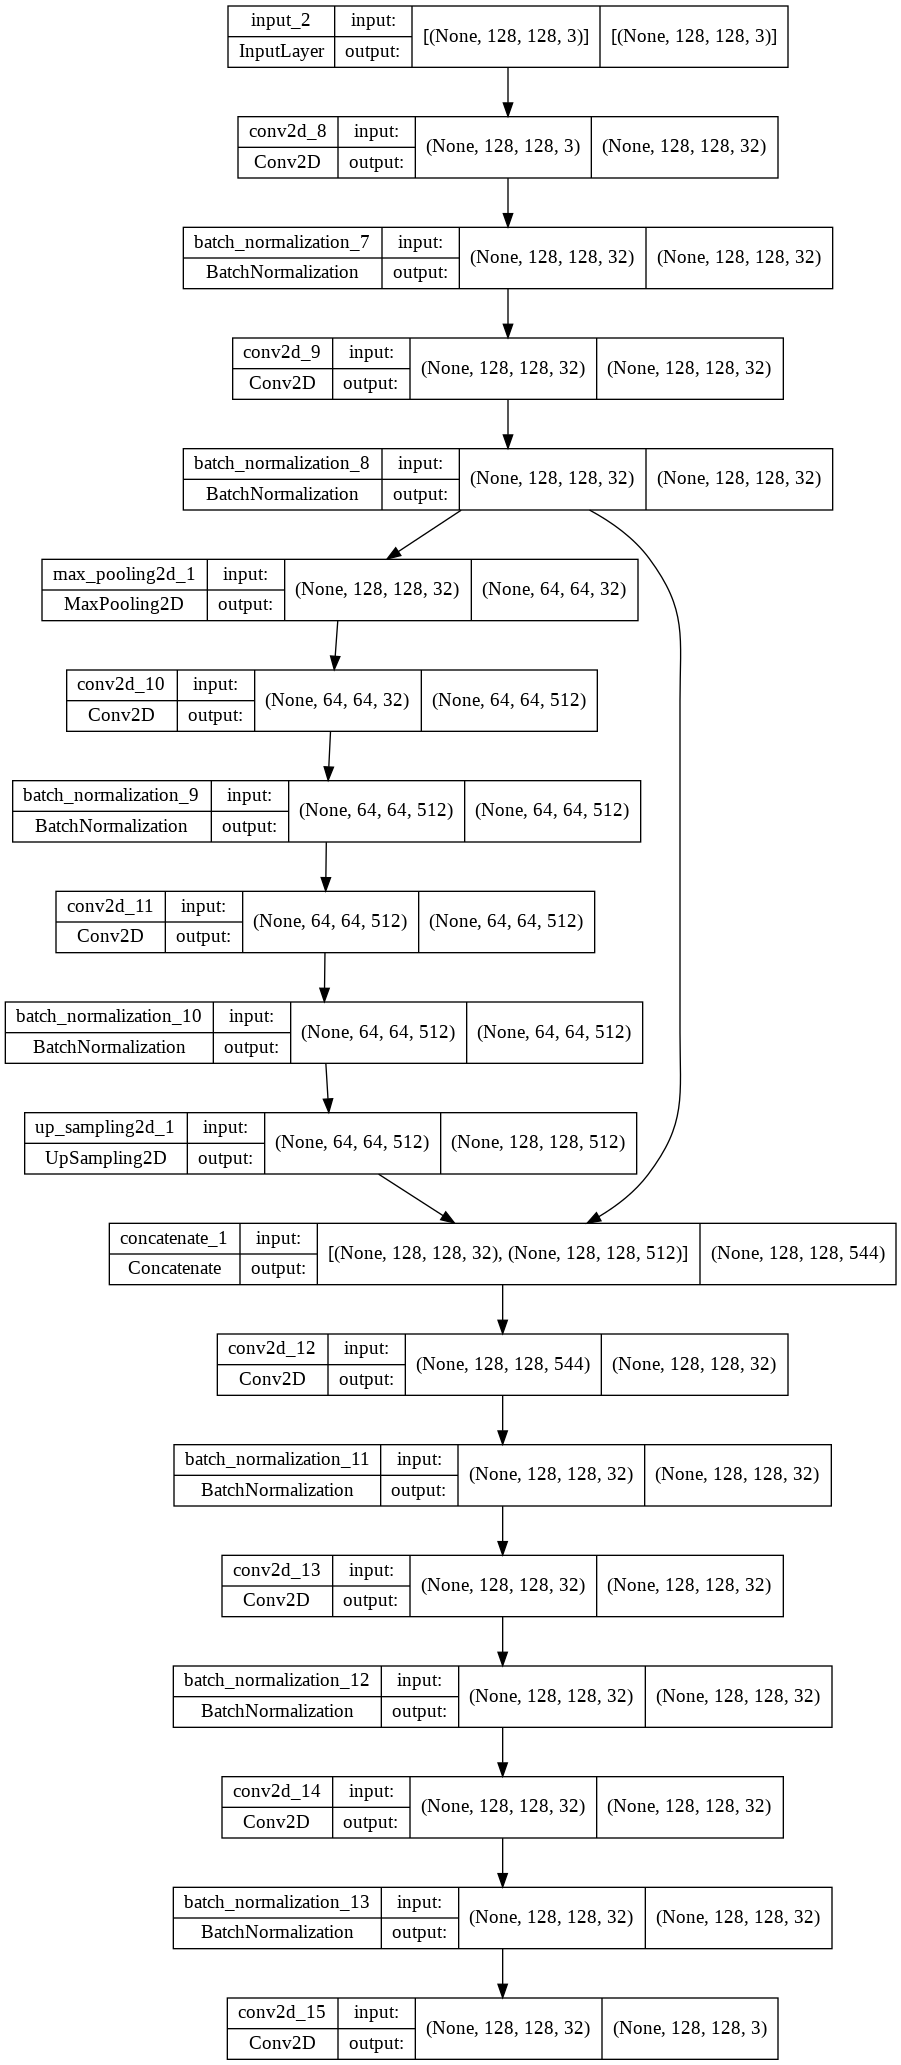

In [12]:
tf.keras.utils.plot_model(UNET, show_shapes=True)

Epoch 1/5
735/735 - 227s - loss: 0.6830 - accuracy: 0.7071 - 227s/epoch - 309ms/step
Epoch 2/5
735/735 - 215s - loss: 0.5637 - accuracy: 0.7676 - 215s/epoch - 292ms/step
Epoch 3/5
735/735 - 214s - loss: 0.5225 - accuracy: 0.7870 - 214s/epoch - 291ms/step
Epoch 4/5
735/735 - 214s - loss: 0.5042 - accuracy: 0.7961 - 214s/epoch - 291ms/step
Epoch 5/5
735/735 - 214s - loss: 0.4856 - accuracy: 0.8042 - 214s/epoch - 291ms/step
184/184 - 80s - loss: 0.4975 - accuracy: 0.7966 - 80s/epoch - 435ms/step
46/46 - 25s - loss: 0.5053 - accuracy: 0.7927 - 25s/epoch - 541ms/step


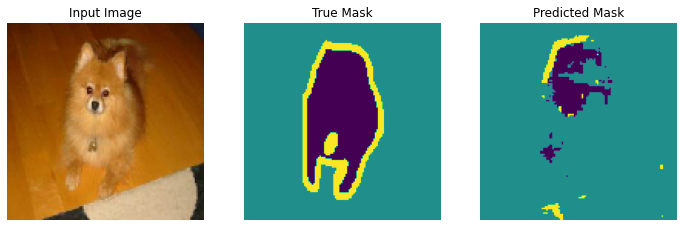

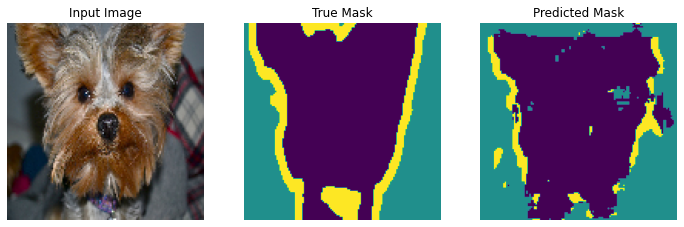

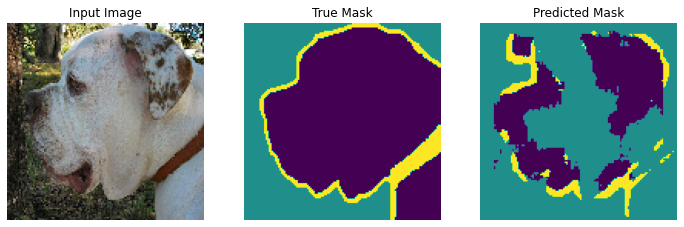

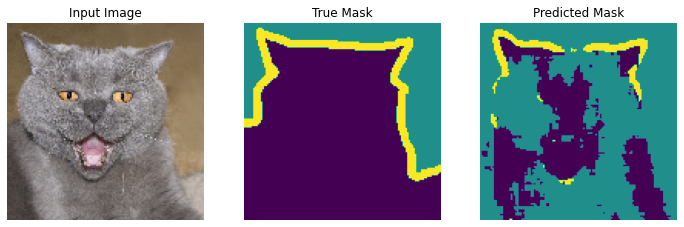

In [13]:
ret = UNET.fit(x_train, y_train, epochs = 5, batch_size = 8, verbose = 2)
'''message:
tensorflow.python.framework.errors_impl.ResourceExhaustedError:  OOM when allocating tensor

solution: reduce batch_size to  8, 4, 2...
'''
train_loss, train_acc = UNET.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc   = UNET.evaluate(x_test,  y_test, verbose=2)

#5:
def display(display_list):
  plt.figure(figsize=(12, 4))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
#6:  
def create_mask(pred_mask):  # (:, 128, 128, 3)
  pred_mask = tf.argmax(pred_mask, axis=-1) # (:, 128, 128), axis=3 
  pred_mask = pred_mask[..., tf.newaxis]    # (:, 128, 128, 1) 
  return pred_mask

# predict segmentation of train data
k = 2
pred_mask = UNET.predict(x_train[:k])  # pred_mask.shape = (k, 128, 128, 3)
pred_mask = create_mask(pred_mask)     # TensorShape([k, 128, 128, 1])

for i in range(k):
    display([x_train[i], y_train[i], pred_mask[i]])

#7: predict segmentation of test dat
pred_mask = UNET.predict(x_test[:k])  # pred_mask.shape = (k, 128, 128, 3)
pred_mask = create_mask(pred_mask)    # TensorShape([k, 128, 128, 1])

for i in range(k):
    display([x_test[i], y_test[i], pred_mask[i]])    

In [14]:
#3: ref1
def unet_2(input_shape=(128, 128, 3), num_classes=3):
  
    inputs = Input(shape=input_shape)
    # 128
    
    down1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(32, (3, 3), activation='relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPool2D()(down1)
    # 64
    
    down2 = Conv2D(64, (3, 3), activation='relu', padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Conv2D(64, (3, 3), activation='relu', padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2_pool = MaxPool2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(128, (3, 3), activation='relu', padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Conv2D(128, (3, 3), activation='relu', padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3_pool = MaxPool2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(256, (3, 3), activation='relu', padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Conv2D(256, (3, 3), activation='relu', padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4_pool = MaxPool2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(512, (3, 3), activation='relu', padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Conv2D(512, (3, 3), activation='relu', padding='same')(center)
    center = BatchNormalization()(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    
    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)

    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)

    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)    
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    # 128

    classify = Conv2D(3, (1, 1), padding='same', activation='sigmoid')(up1)   
    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=RMSprop(0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])    
    return model

In [15]:
#4:
UNET = unet_2()
UNET.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 128, 128, 32  128        ['conv2d_16[0][0]']              
 ormalization)                  )                                                           

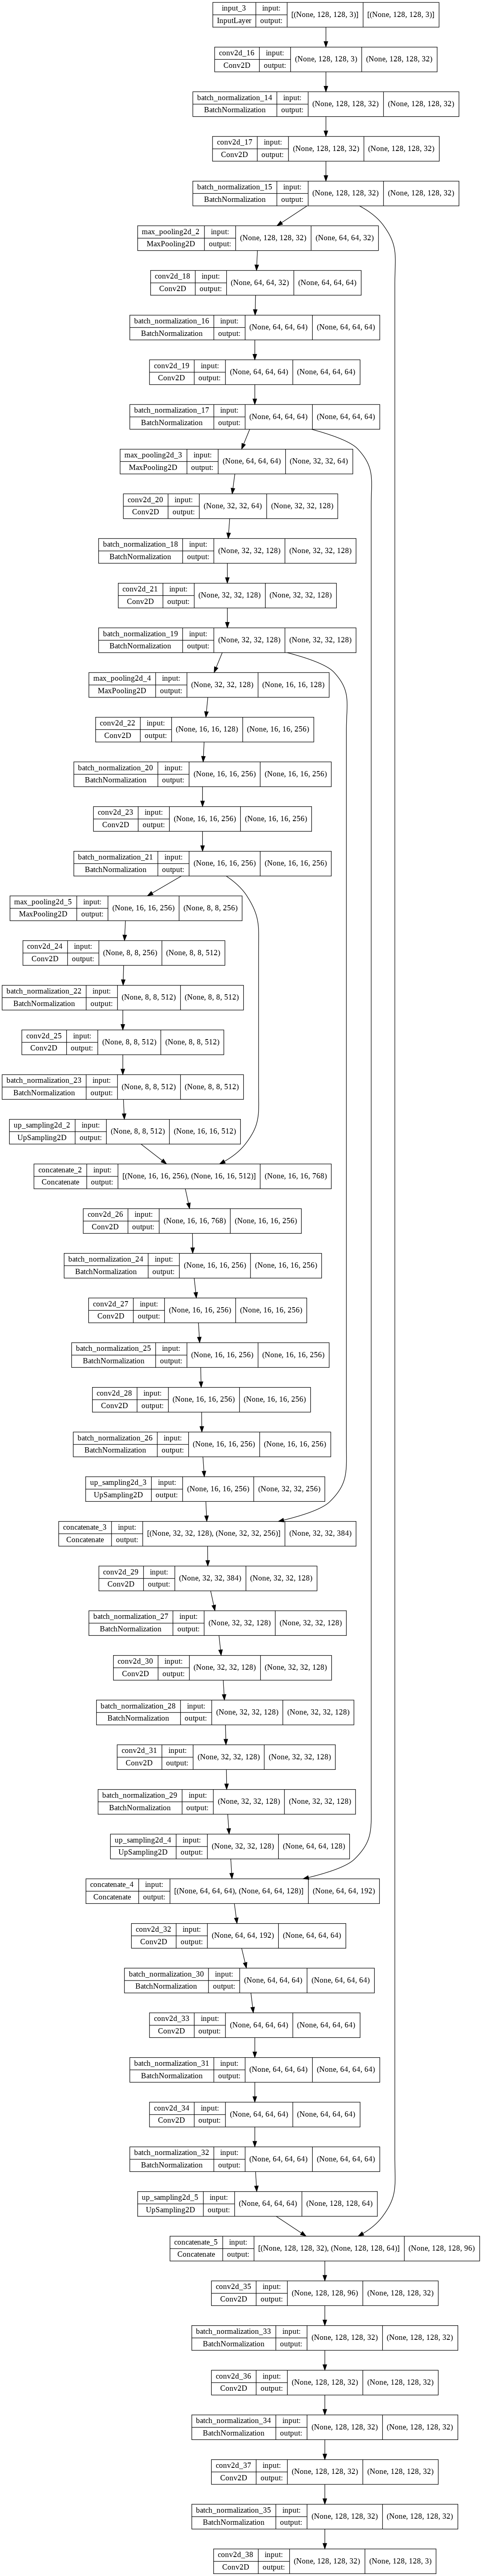

In [16]:
tf.keras.utils.plot_model(UNET, show_shapes=True)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


735/735 - 142s - loss: 0.6547 - accuracy: 0.7288 - 142s/epoch - 193ms/step
Epoch 2/5
735/735 - 134s - loss: 0.4521 - accuracy: 0.8234 - 134s/epoch - 183ms/step
Epoch 3/5
735/735 - 134s - loss: 0.3941 - accuracy: 0.8476 - 134s/epoch - 183ms/step
Epoch 4/5
735/735 - 134s - loss: 0.3609 - accuracy: 0.8616 - 134s/epoch - 183ms/step
Epoch 5/5
735/735 - 134s - loss: 0.3318 - accuracy: 0.8729 - 134s/epoch - 183ms/step
184/184 - 30s - loss: 0.3182 - accuracy: 0.8785 - 30s/epoch - 161ms/step
46/46 - 9s - loss: 0.3429 - accuracy: 0.8697 - 9s/epoch - 191ms/step


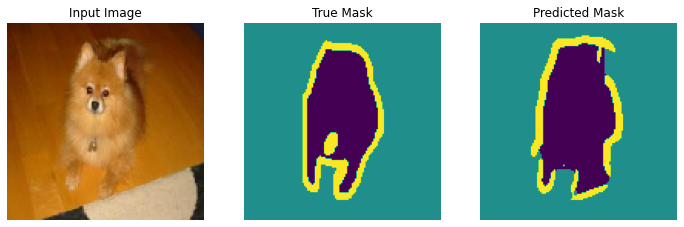

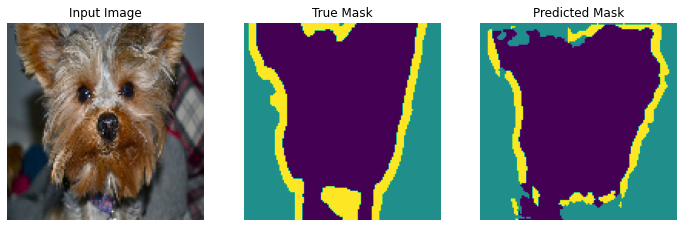

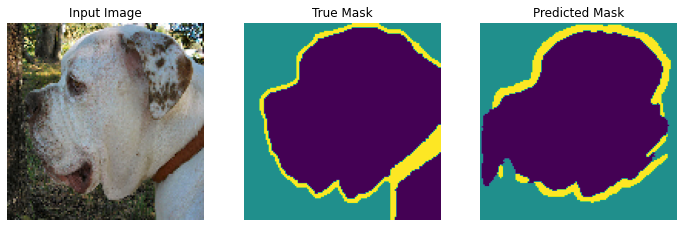

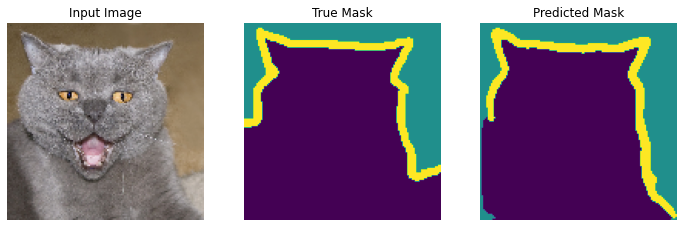

In [17]:
ret = UNET.fit(x_train, y_train, epochs = 5, batch_size = 8, verbose = 2)
'''message:
tensorflow.python.framework.errors_impl.ResourceExhaustedError:  OOM when allocating tensor

solution: reduce batch_size to  8, 4, 2...
'''
train_loss, train_acc = UNET.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc   = UNET.evaluate(x_test,  y_test, verbose=2)

#5:
def display(display_list):
  plt.figure(figsize=(12, 4))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
#6:  
def create_mask(pred_mask):  # (:, 128, 128, 3)
  pred_mask = tf.argmax(pred_mask, axis=-1) # (:, 128, 128), axis=3 
  pred_mask = pred_mask[..., tf.newaxis]    # (:, 128, 128, 1) 
  return pred_mask

# predict segmentation of train data
k = 2
pred_mask = UNET.predict(x_train[:k])  # pred_mask.shape = (k, 128, 128, 3)
pred_mask = create_mask(pred_mask)     # TensorShape([k, 128, 128, 1])

for i in range(k):
    display([x_train[i], y_train[i], pred_mask[i]])

#7: predict segmentation of test dat
pred_mask = UNET.predict(x_test[:k])  # pred_mask.shape = (k, 128, 128, 3)
pred_mask = create_mask(pred_mask)    # TensorShape([k, 128, 128, 1])

for i in range(k):
    display([x_test[i], y_test[i], pred_mask[i]]) 